In [9]:
import pandas as pd

from src.dataset import load_dataset
import matplotlib.pyplot as plt
import math

#### Caricamento e preparazione del dataset
In questa sezione vengono caricati i dataset di training relativi alle feature operative (X) e alle variabili target (y).
Successivamente, i due dataset vengono uniti in un unico DataFrame per facilitare l’analisi esplorativa.
Infine, viene ricostruita la variabile trq_target a partire dalla definizione del torque margin.


In [4]:
df_x= load_dataset("../../data/raw/train/X_train.csv")
df_y = load_dataset("../../data/raw/train/y_train.csv")
df= pd.concat([df_x,df_y],axis=1)
df["trq_target"] = df["trq_measured"] / (df["trq_margin"] / 100 + 1)

#### Statistiche descrittive di base
Vengono calcolate le statistiche descrittive principali per ottenere una prima visione dei range, della variabilità e dei valori centrali delle variabili.
Questo passaggio consente di individuare eventuali valori anomali e di comprendere le scale delle feature.

In [18]:
df.describe(percentiles=[0.5])

id   trq_measured            oat            mgt  \
count  742625.000000  742625.000000  742625.000000  742625.000000   
mean   371312.000000      65.097549      12.675167     592.246116   
std    214377.516166      13.253672       8.066084      39.654582   
min         0.000000      14.673340     -19.250000     467.300000   
50%    371312.000000      65.700000      13.703440     589.400000   
max    742624.000000     104.730500      36.799130     723.400000   

                  pa            ias             np             ng  \
count  742625.000000  742625.000000  742625.000000  742625.000000   
mean      511.776065      79.324591      97.377919      95.517281   
std       563.190555      35.395075       3.996721       3.635084   
min      -208.389200       0.000000      85.010000      90.001830   
50%       340.461600      88.375000      99.759770      94.810000   
max      3097.510000     137.562500     101.560000     101.220000   

                  id         faulty     trq_margin     trq_target  
count  742625.000000  742625.000000  742625.000000  742625.000000  
mean   371312.000000       0.403189      -1.157346      66.711490  
std    214377.516166       0.490538      14.068843      14.170206  
min         0.000000       0.000000     -74.747111      22.454554  
50%    371312.000000       0.000000       1.693847      66.001495  
max    742624.000000       1.000000      34.148857     114.608196

#### Distribuzione della classe di salute (faulty)
In questa sezione viene analizzata la distribuzione della variabile target faulty, che rappresenta lo stato di salute del motore:
- 0 = stato nominale
- 1 = stato guasto
L’obiettivo è verificare l’eventuale presenza di sbilanciamento tra le classi, aspetto cruciale per il task di classificazione.

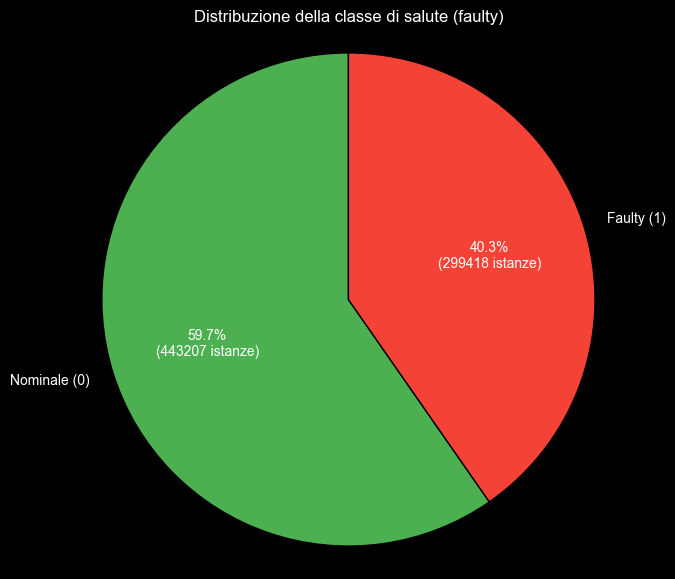

In [21]:
faulty_counts = df["faulty"].value_counts().sort_index()
labels = ["Nominale (0)", "Faulty (1)"]
colors = ["#4CAF50", "#F44336"]


def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        count = int(round(pct * total / 100.0))
        return f"{pct:.1f}%\n({count} istanze)"
    return my_format

plt.figure(figsize=(7, 7))
plt.pie(
    faulty_counts,
    labels=labels,
    autopct=autopct_format(faulty_counts.values),
    startangle=90,
    colors=colors,
    wedgeprops={"edgecolor": "black"}
)

plt.title("Distribuzione della classe di salute (faulty)")
plt.axis("equal")
plt.show()

La distribuzione della variabile faulty mostra uno sbilanciamento tra le classi, con una prevalenza di osservazioni in stato nominale rispetto a quelle guaste. Questo aspetto dovrà essere considerato nella fase di modellazione della classificazione.

## Influenza dello stato di salute sulle feature operative
In questa sezione viene analizzata l’influenza dello stato di salute del motore sulle principali feature operative.
L’obiettivo è verificare se le variabili misurate mostrino comportamenti differenti quando il motore opera in condizioni nominali (faulty = 0) rispetto a condizioni di guasto (faulty = 1).
Questa analisi rappresenta un passaggio fondamentale dell’Exploratory Data Analysis, in quanto consente di valutare il potenziale informativo delle singole feature rispetto allo stato di salute del motore e di guidare le successive fasi di selezione delle variabili e di modellazione.
Il confronto viene effettuato analizzando le distribuzioni delle feature nei due stati di salute attraverso rappresentazioni grafiche in grado di evidenziare differenze in termini di valore centrale, variabilità e forma della distribuzione.

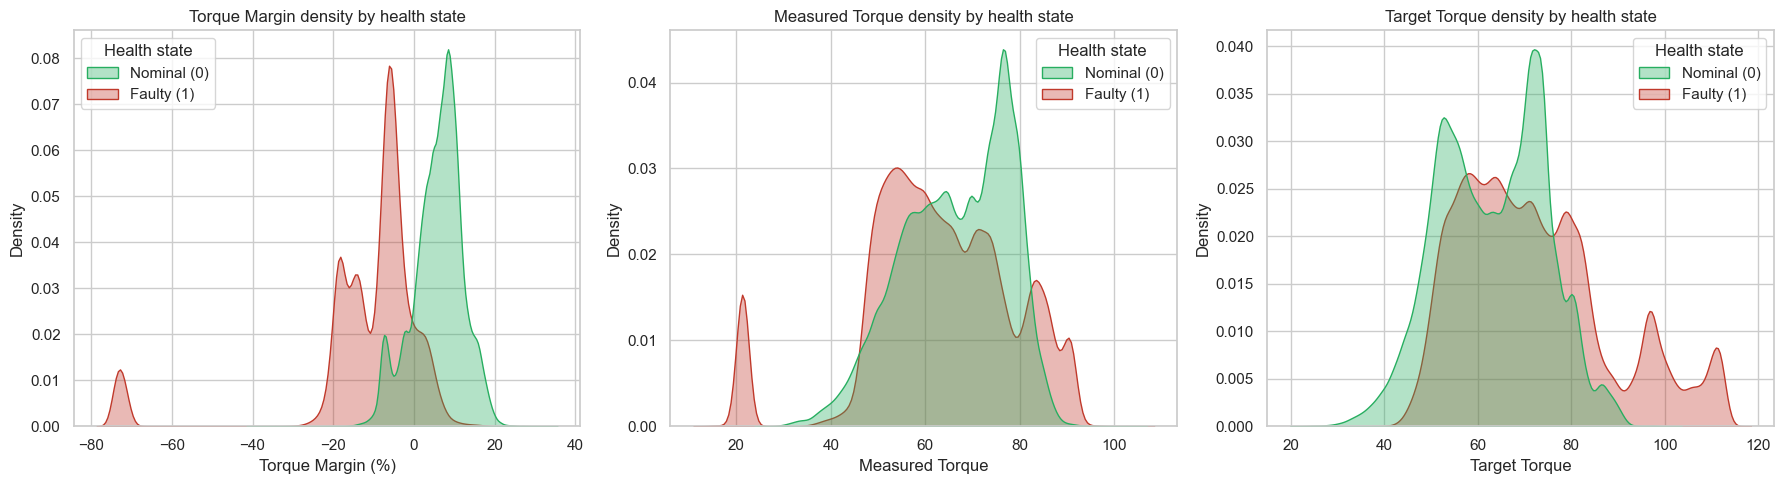

In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

cols_to_num = ["trq_margin", "trq_measured", "trq_target", "faulty"]
for c in cols_to_num:
    df[c] = pd.to_numeric(df[c], errors="coerce")

sns.set_style("whitegrid")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

kde_config = [
    ("trq_margin", "Torque Margin (%)", "Torque Margin density by health state"),
    ("trq_measured", "Measured Torque", "Measured Torque density by health state"),
    ("trq_target", "Target Torque", "Target Torque density by health state"),
]

palette = {0: "#27ae60", 1: "#c0392b"}  # 0=Nominal (verde), 1=Faulty (rosso)

for ax, (col, xlabel, title) in zip(axes, kde_config):
    sns.kdeplot(
        data=df,
        x=col,
        hue="faulty",
        hue_order=[0, 1],
        fill=True,
        common_norm=False,
        palette=palette,
        alpha=0.35,
        ax=ax
    )
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Density")

    leg = ax.get_legend()
    if leg is not None:
        leg.set_title("Health state")
        leg.texts[0].set_text("Nominal (0)")
        leg.texts[1].set_text("Faulty (1)")

plt.tight_layout()
plt.show()


### Analisi tramite box plot

I box plot vengono utilizzati come primo strumento di analisi per confrontare le distribuzioni delle feature operative tra motori nominali e guasti.
Questo tipo di grafico fornisce una sintesi robusta delle distribuzioni, basata sui quartili, ed è particolarmente adatto a individuare differenze sistematiche tra gruppi.
In particolare, i box plot consentono di:
- confrontare le mediane delle feature nei due stati di salute;
- osservare eventuali differenze nella dispersione dei dati;
- individuare la presenza di outlier, spesso associabili a condizioni operative anomale;
- valutare in modo preliminare il potere discriminante delle variabili rispetto allo stato di salute.

Le feature che mostrano uno spostamento significativo della mediana o una maggiore variabilità nello stato di guasto vengono considerate potenzialmente rilevanti e approfondite nelle analisi successive.

/var/folders/m6/m0y2tv6x59jgbs_pkb4r423c0000gn/T/ipykernel_48492/3513469877.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/m6/m0y2tv6x59jgbs_pkb4r423c0000gn/T/ipykernel_48492/3513469877.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/m6/m0y2tv6x59jgbs_pkb4r423c0000gn/T/ipykernel_48492/3513469877.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/m6/m0y2tv6x59jgbs_pkb4r423c0000gn/T/ipykernel_48492/3513469877.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated a

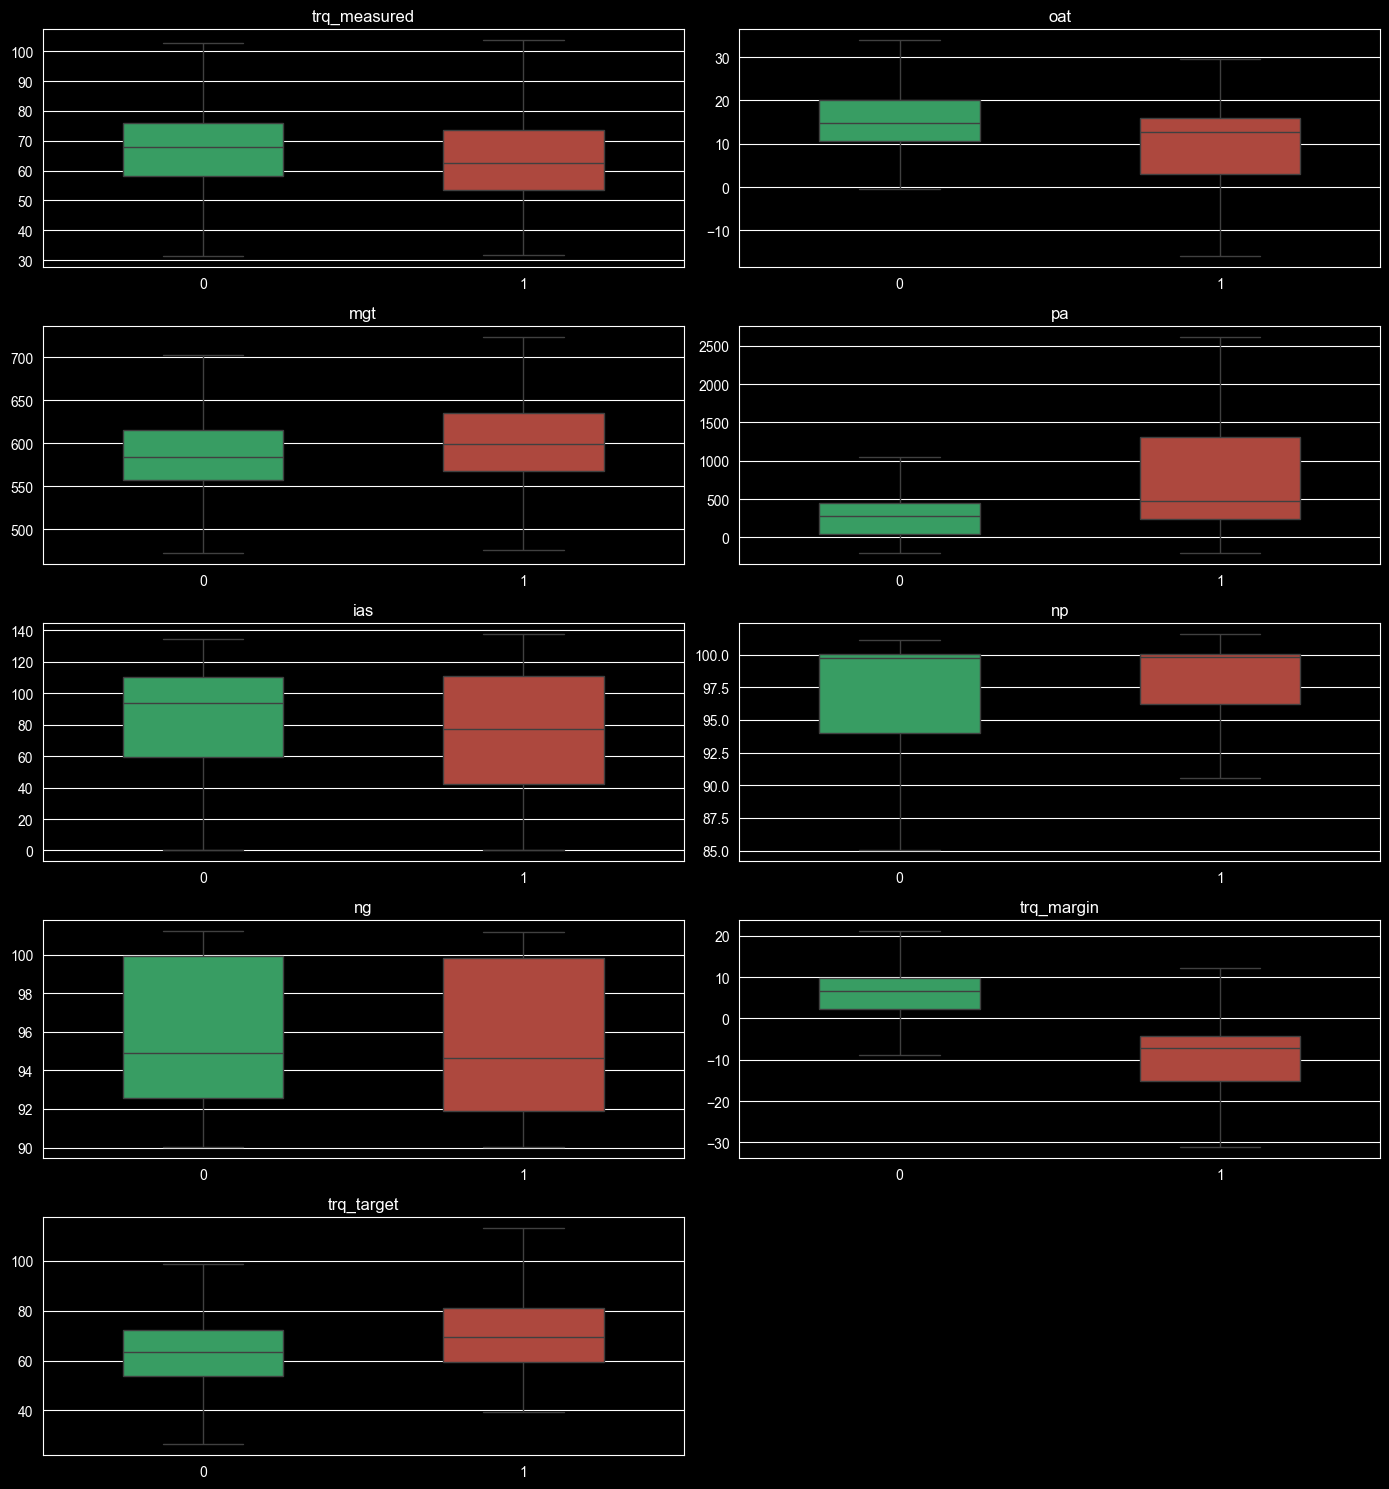

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# feature list (escludo id e faulty)
features = [c for c in df.columns if c.lower() not in ["id", "faulty"]]

# figura dinamica
n = len(features)
rows = (n + 1) // 2
plt.figure(figsize=(14, rows * 3))

palette = {'0': "#27ae60", '1': "#c0392b"}  # nominal / faulty

for i, feat in enumerate(features, 1):
    plt.subplot(rows, 2, i)
    sns.boxplot(
        x=df_y["faulty"],
        y=df[feat],
        palette=palette,
        showfliers=False,
        width=0.5
    )
    plt.title(feat)
    plt.xlabel("")
    plt.ylabel("")

plt.tight_layout()
plt.show()


## Violin

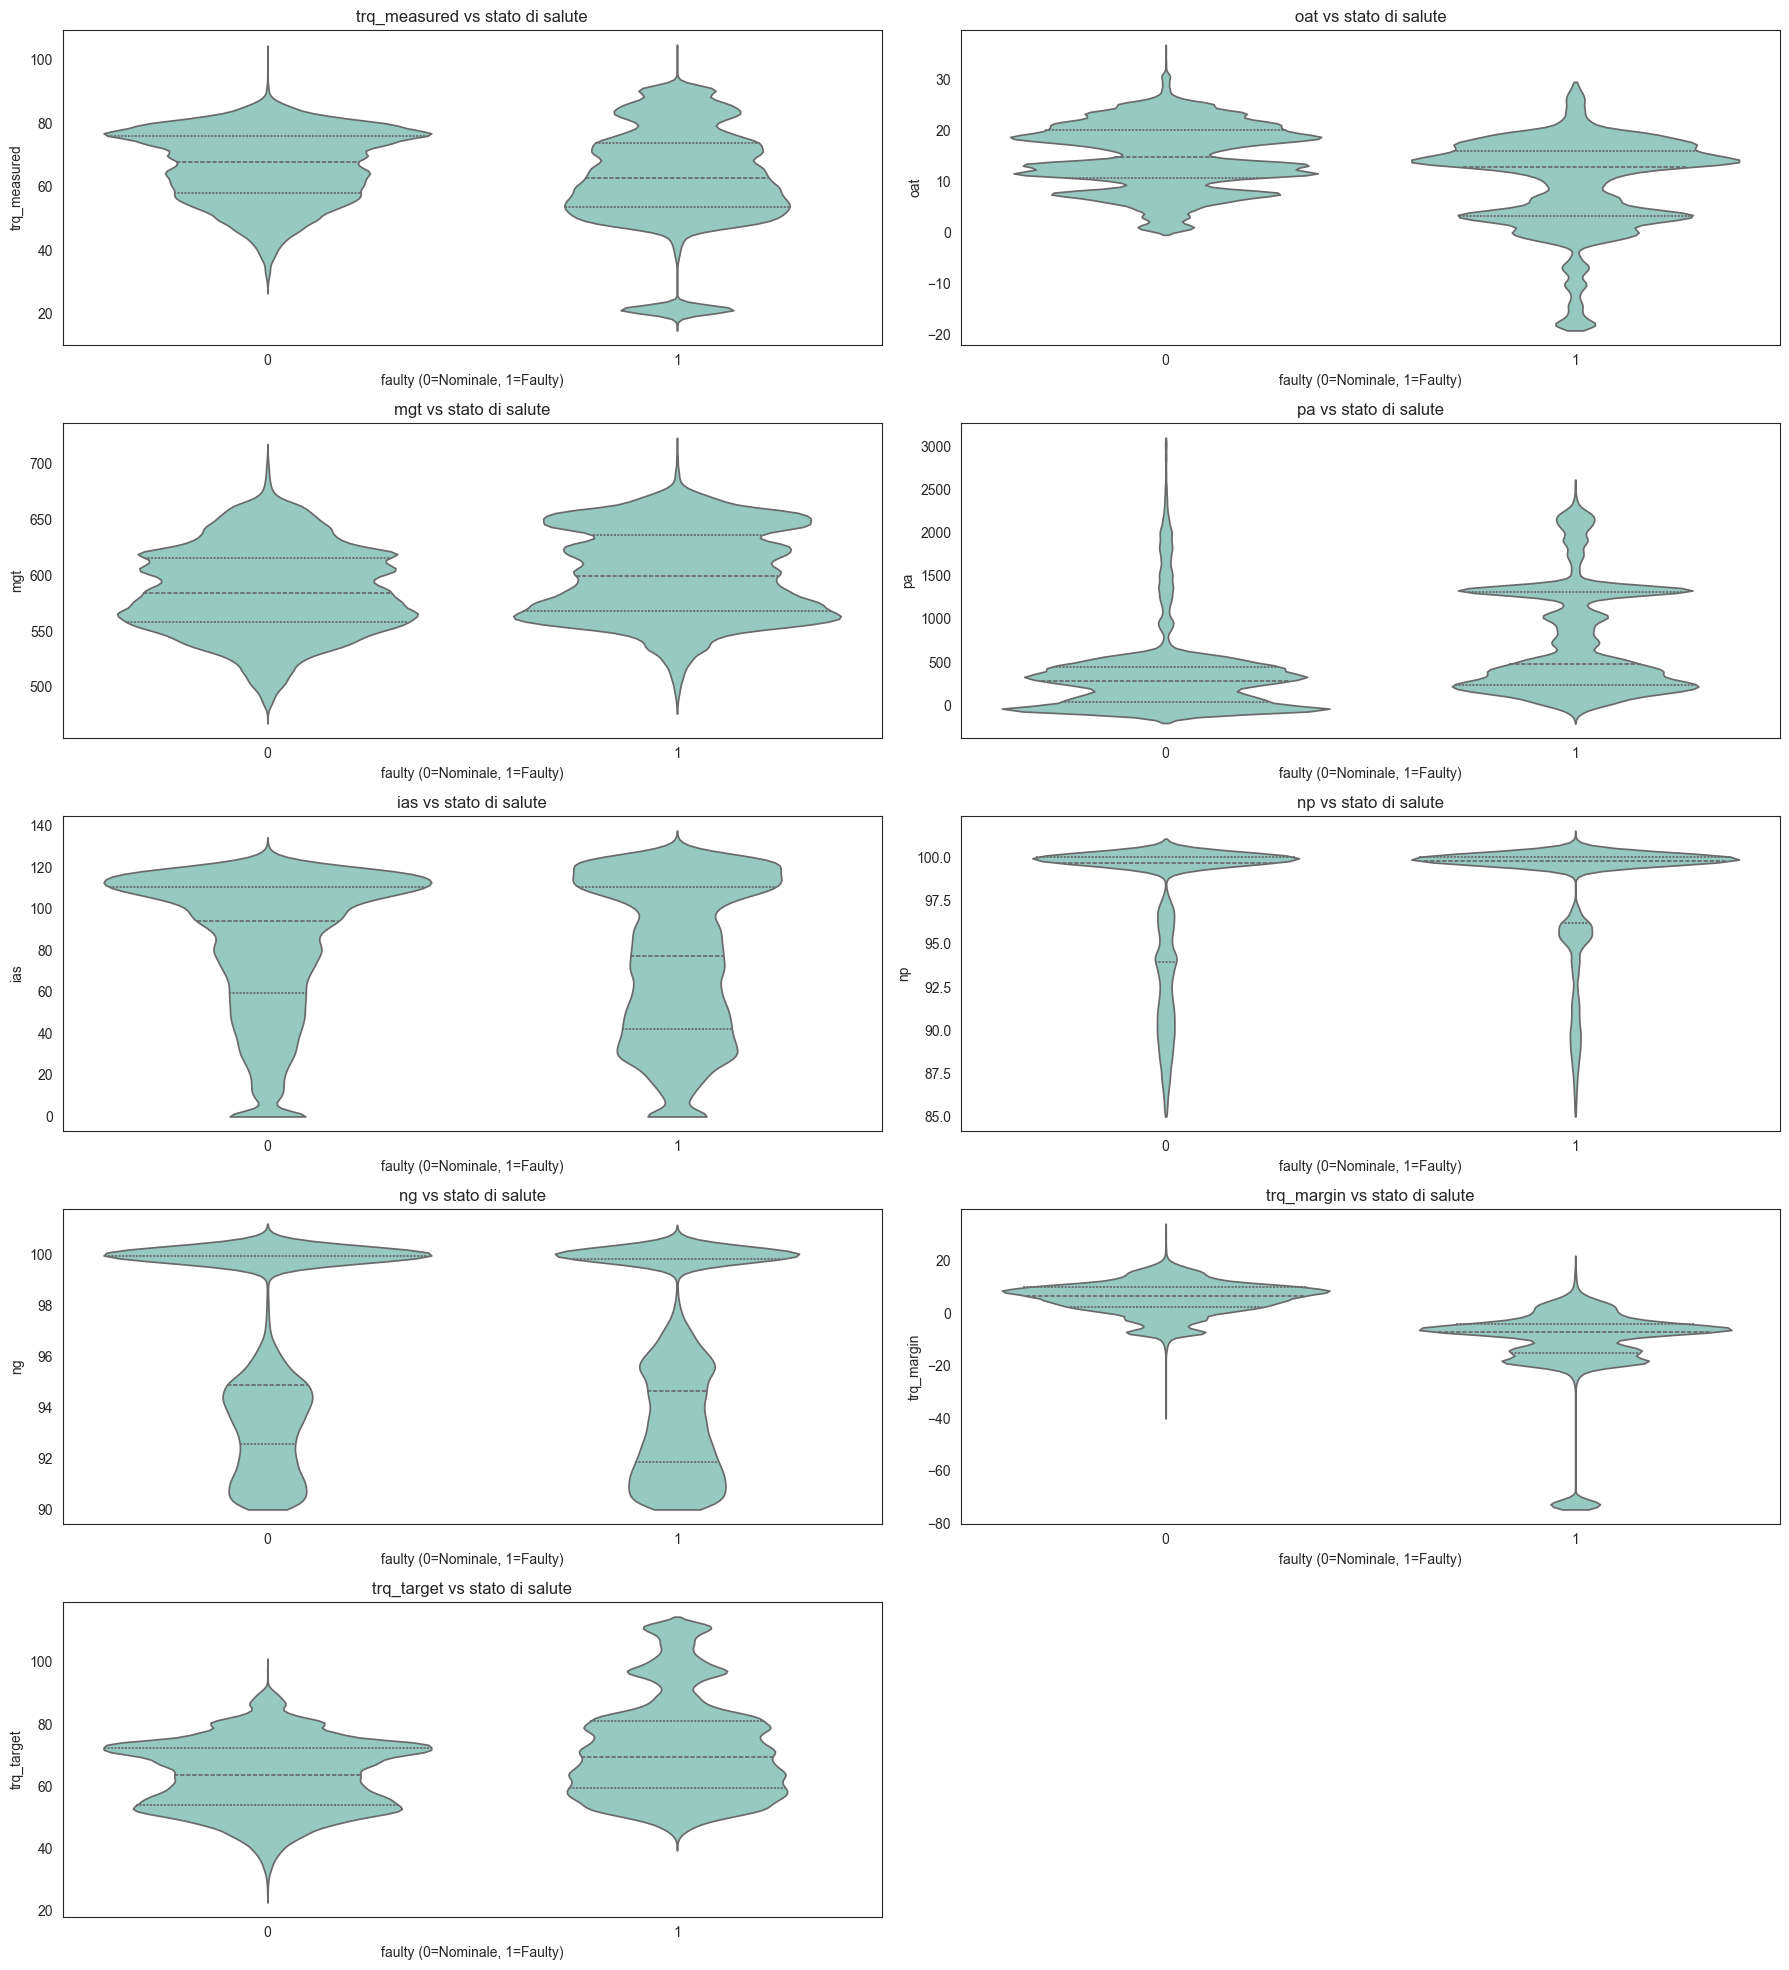

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

features = [col for col in df.columns if col.lower() not in ["id", "faulty"]]

plt.figure(figsize=(18, len(features) * 2.2))

for i, feature in enumerate(features, 1):
    plt.subplot((len(features) + 1) // 2, 2, i)
    sns.violinplot(
        x=df_y["faulty"],
        y=df[feature],
        inner="quartile",
        cut=0
    )
    plt.xlabel("faulty (0=Nominale, 1=Faulty)")
    plt.ylabel(feature)
    plt.title(f"{feature} vs stato di salute")

plt.tight_layout()
plt.show()

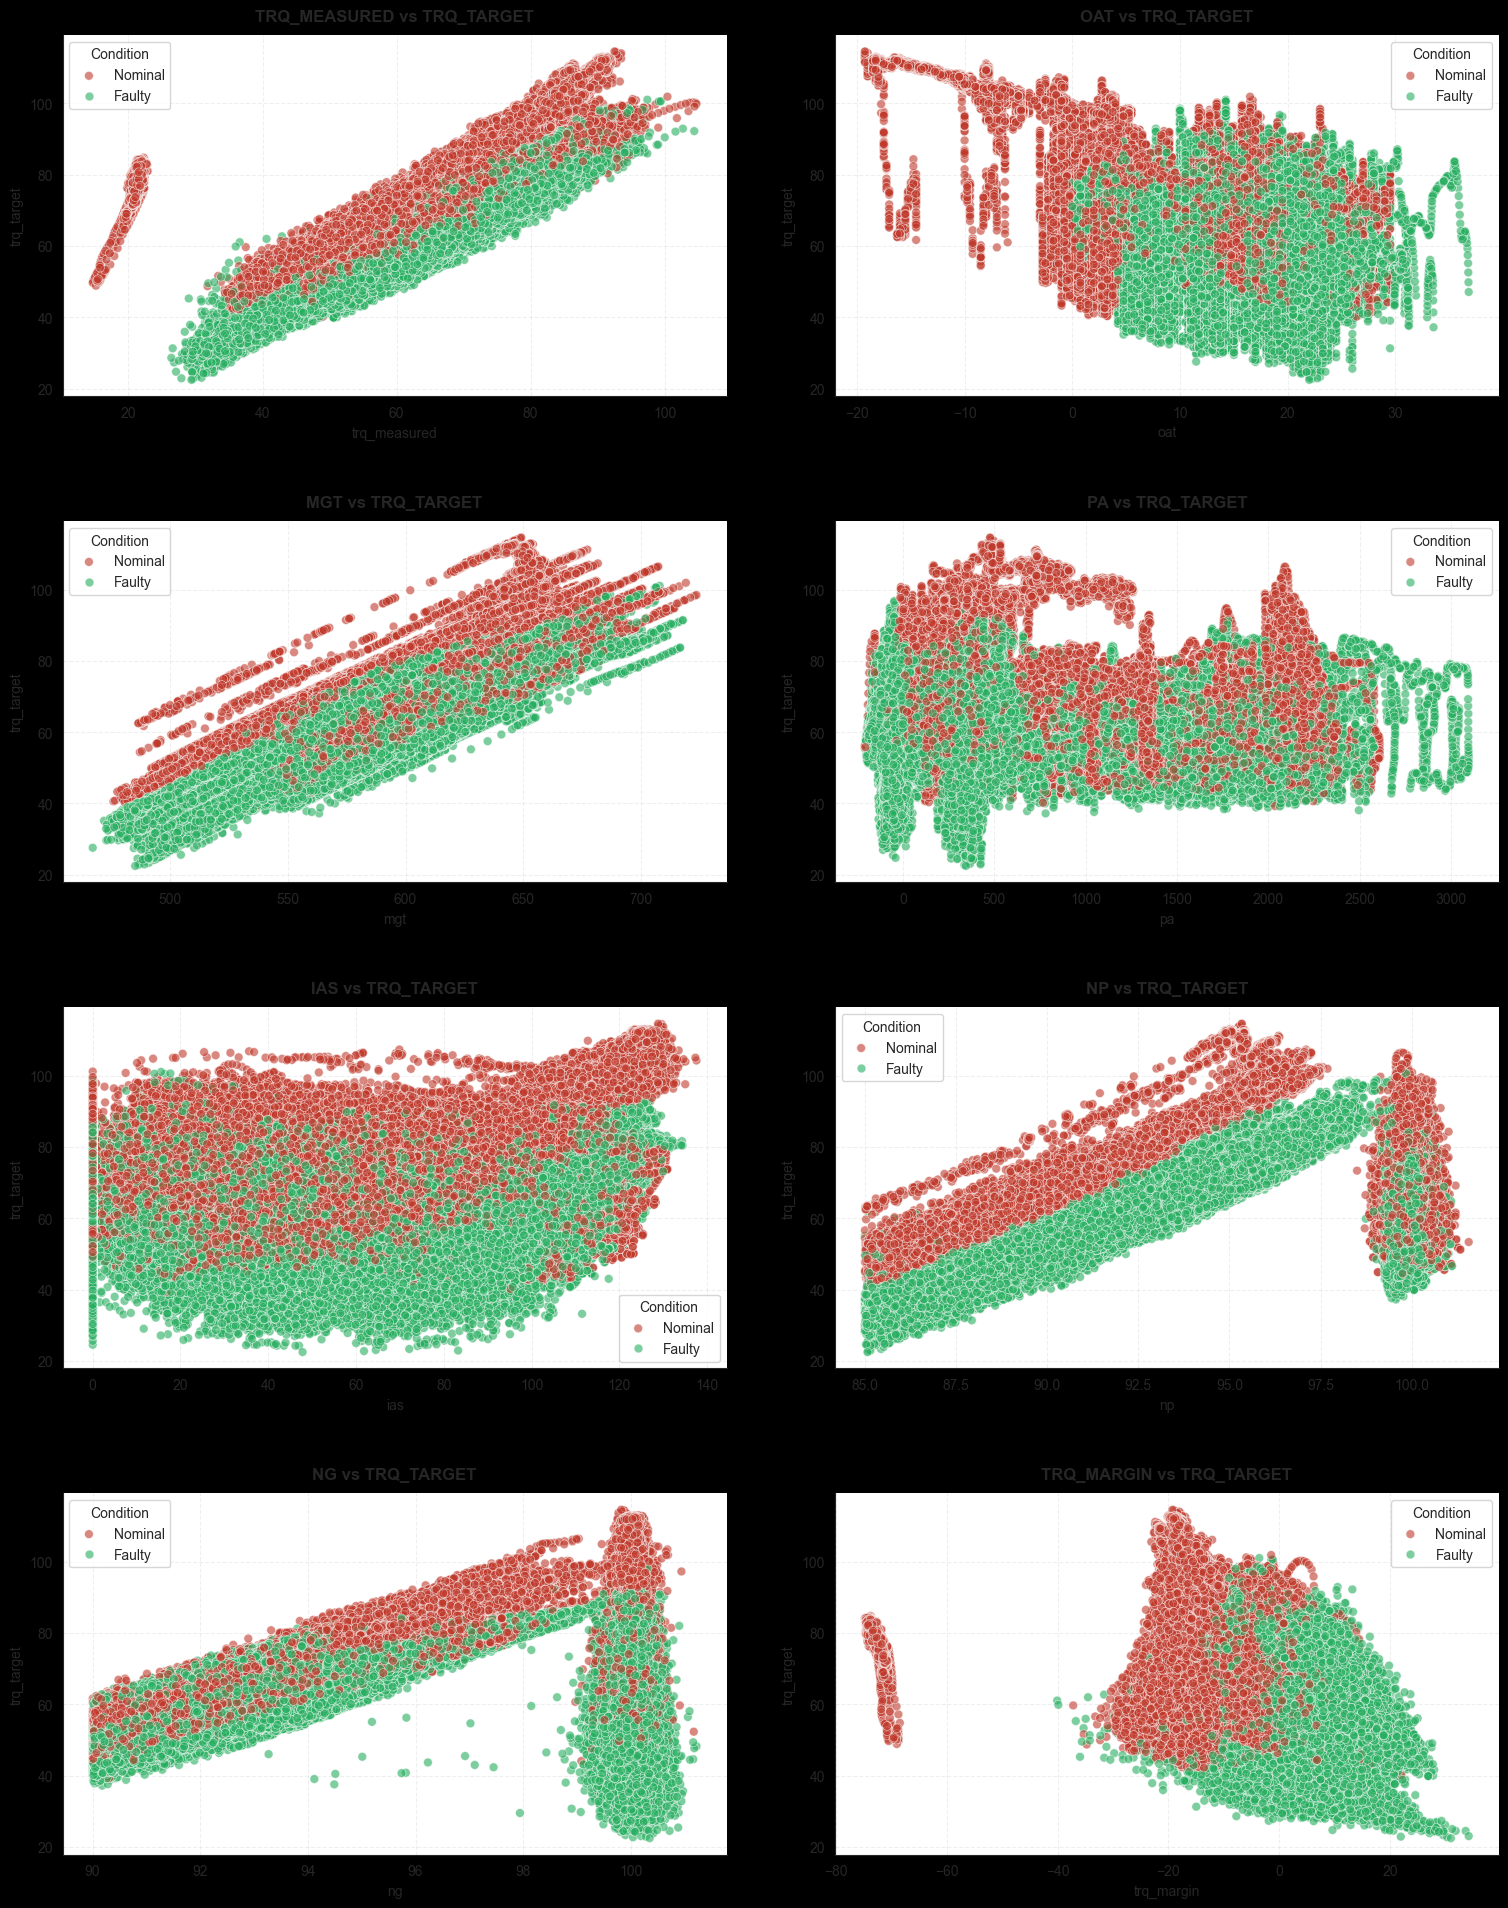

In [6]:
target_x = 'trq_target'
features = [col for col in df.columns if col not in [target_x, 'id', 'faulty']]


n_cols = 2
n_rows = math.ceil(len(features) / n_cols)

plt.figure(figsize=(16, n_rows * 5))
sns.set_style("white")

for i, feature in enumerate(features, 1):
    ax = plt.subplot(n_rows, n_cols, i)

    sns.scatterplot(
        data=df,
        x=feature,
        y=target_x,
        hue='faulty',
        palette={0: "#27ae60", 1: "#c0392b"},
        alpha=0.6,
        s=40,
        edgecolor='w',
        linewidth=0.5
    )

    sns.despine()
    ax.set_title(f"{feature.upper()} vs {target_x.upper()}", fontsize=12, fontweight='bold', pad=10)
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.legend(title='Condition', labels=['Nominal', 'Faulty'], loc='best', frameon=True)

plt.tight_layout(pad=4.0)
plt.show()

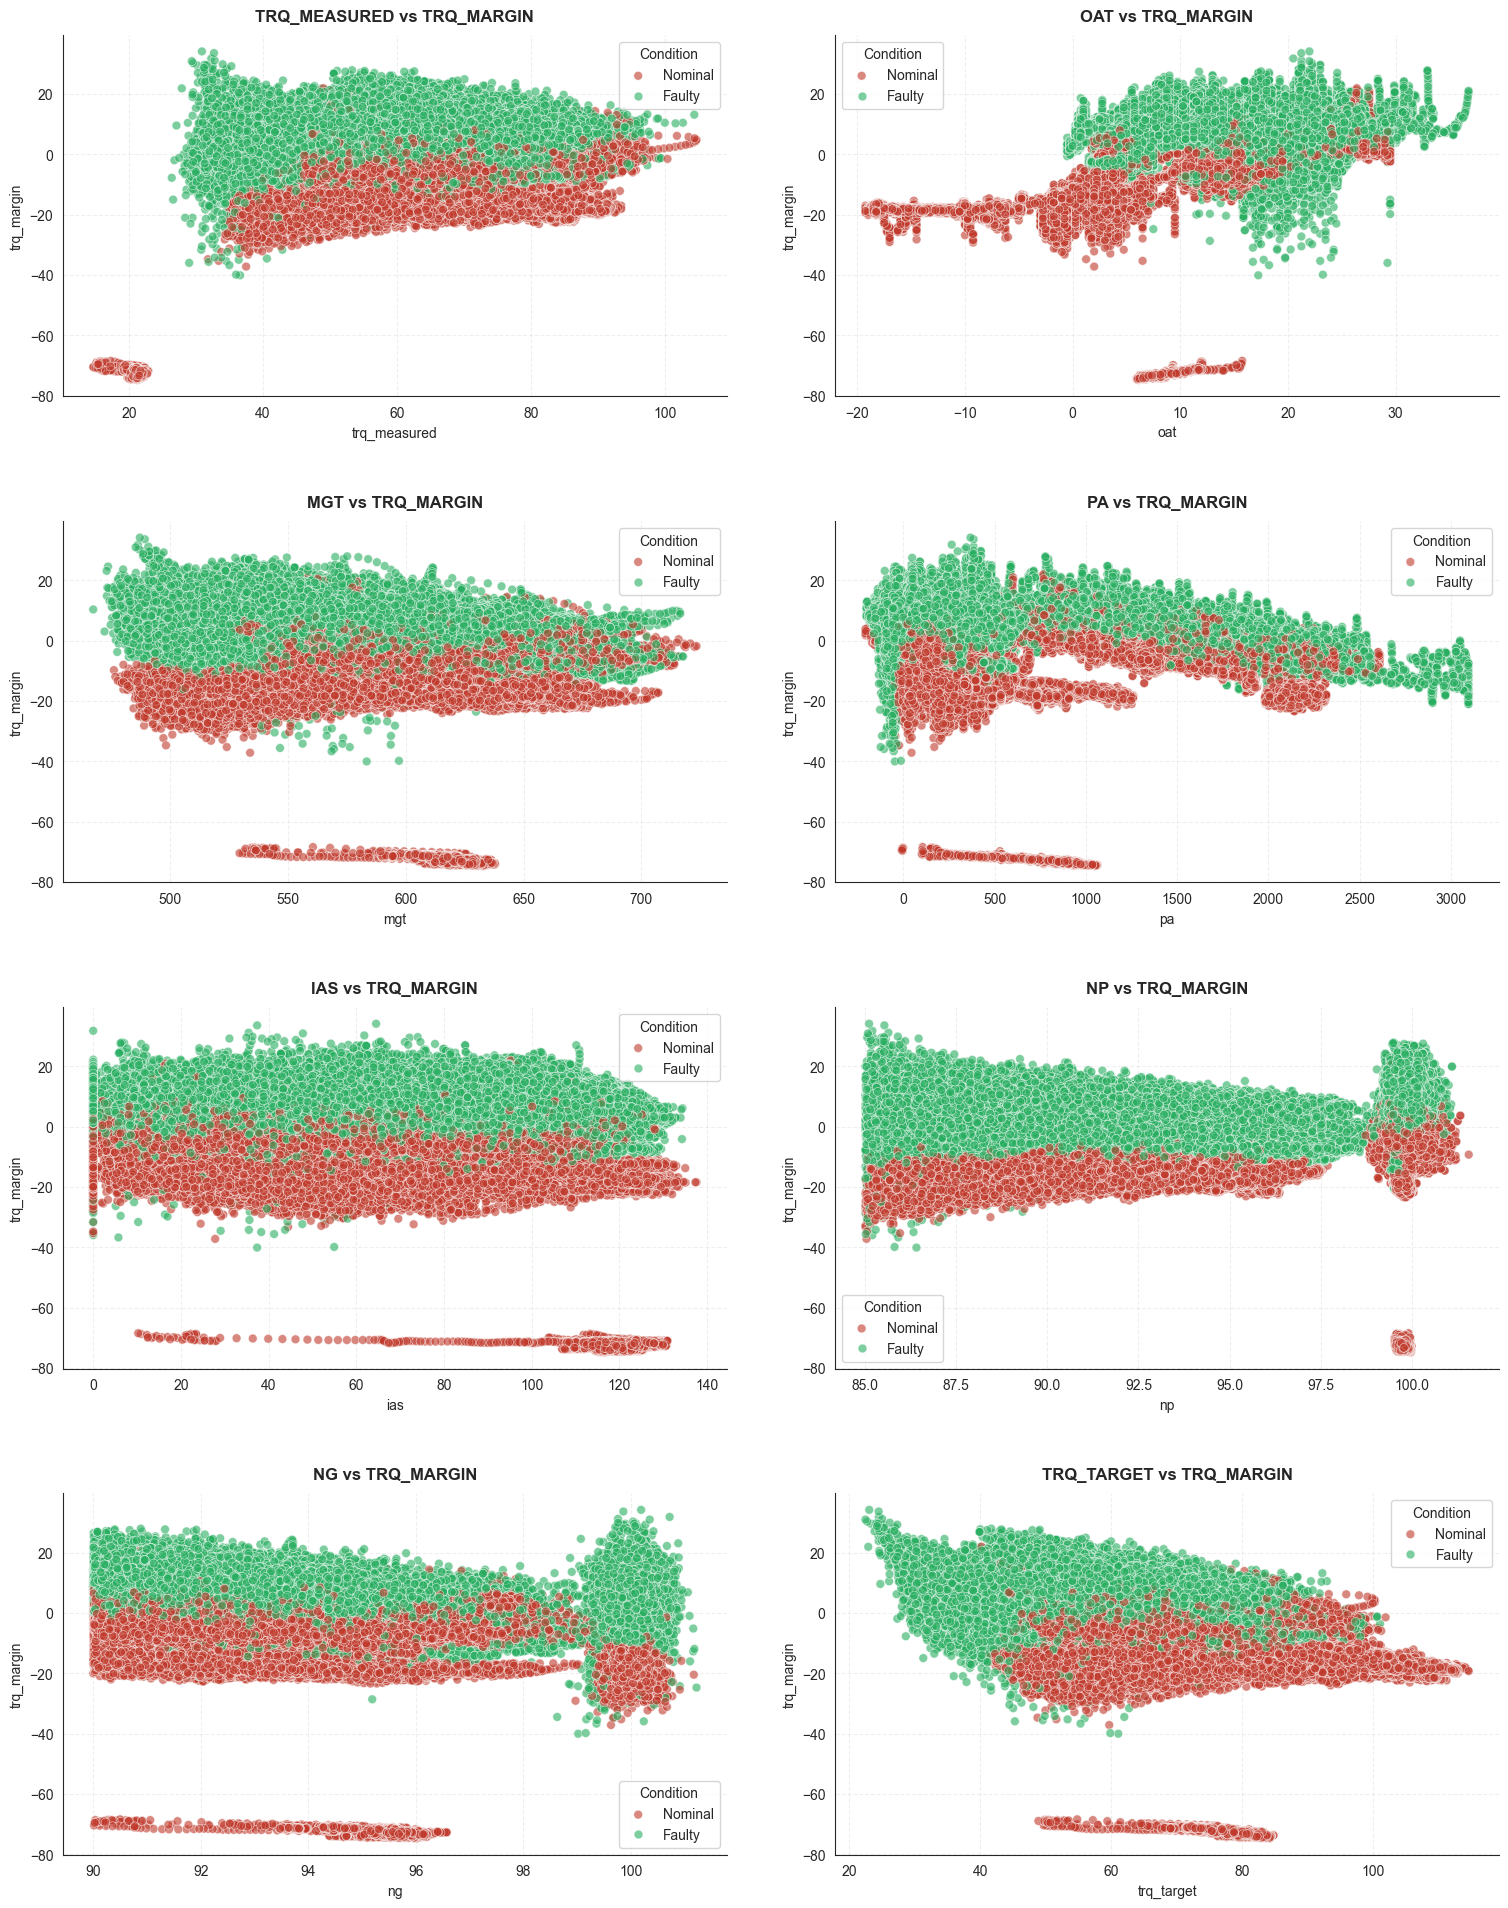

In [10]:
target_x = 'trq_margin'
features = [col for col in df.columns if col not in [target_x, 'id', 'faulty']]

n_cols = 2
n_rows = math.ceil(len(features) / n_cols)

plt.figure(figsize=(16, n_rows * 5))
sns.set_style("white")

for i, feature in enumerate(features, 1):
    ax = plt.subplot(n_rows, n_cols, i)

    sns.scatterplot(
        data=df,
        x=feature,
        y=target_x,
        hue='faulty',
        palette={0: "#27ae60", 1: "#c0392b"},
        alpha=0.6,
        s=40,
        edgecolor='w',
        linewidth=0.5
    )

    sns.despine()
    ax.set_title(f"{feature.upper()} vs {target_x.upper()}", fontsize=12, fontweight='bold', pad=10)
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.legend(title='Condition', labels=['Nominal', 'Faulty'], loc='best', frameon=True)

plt.tight_layout(pad=4.0)
plt.show()

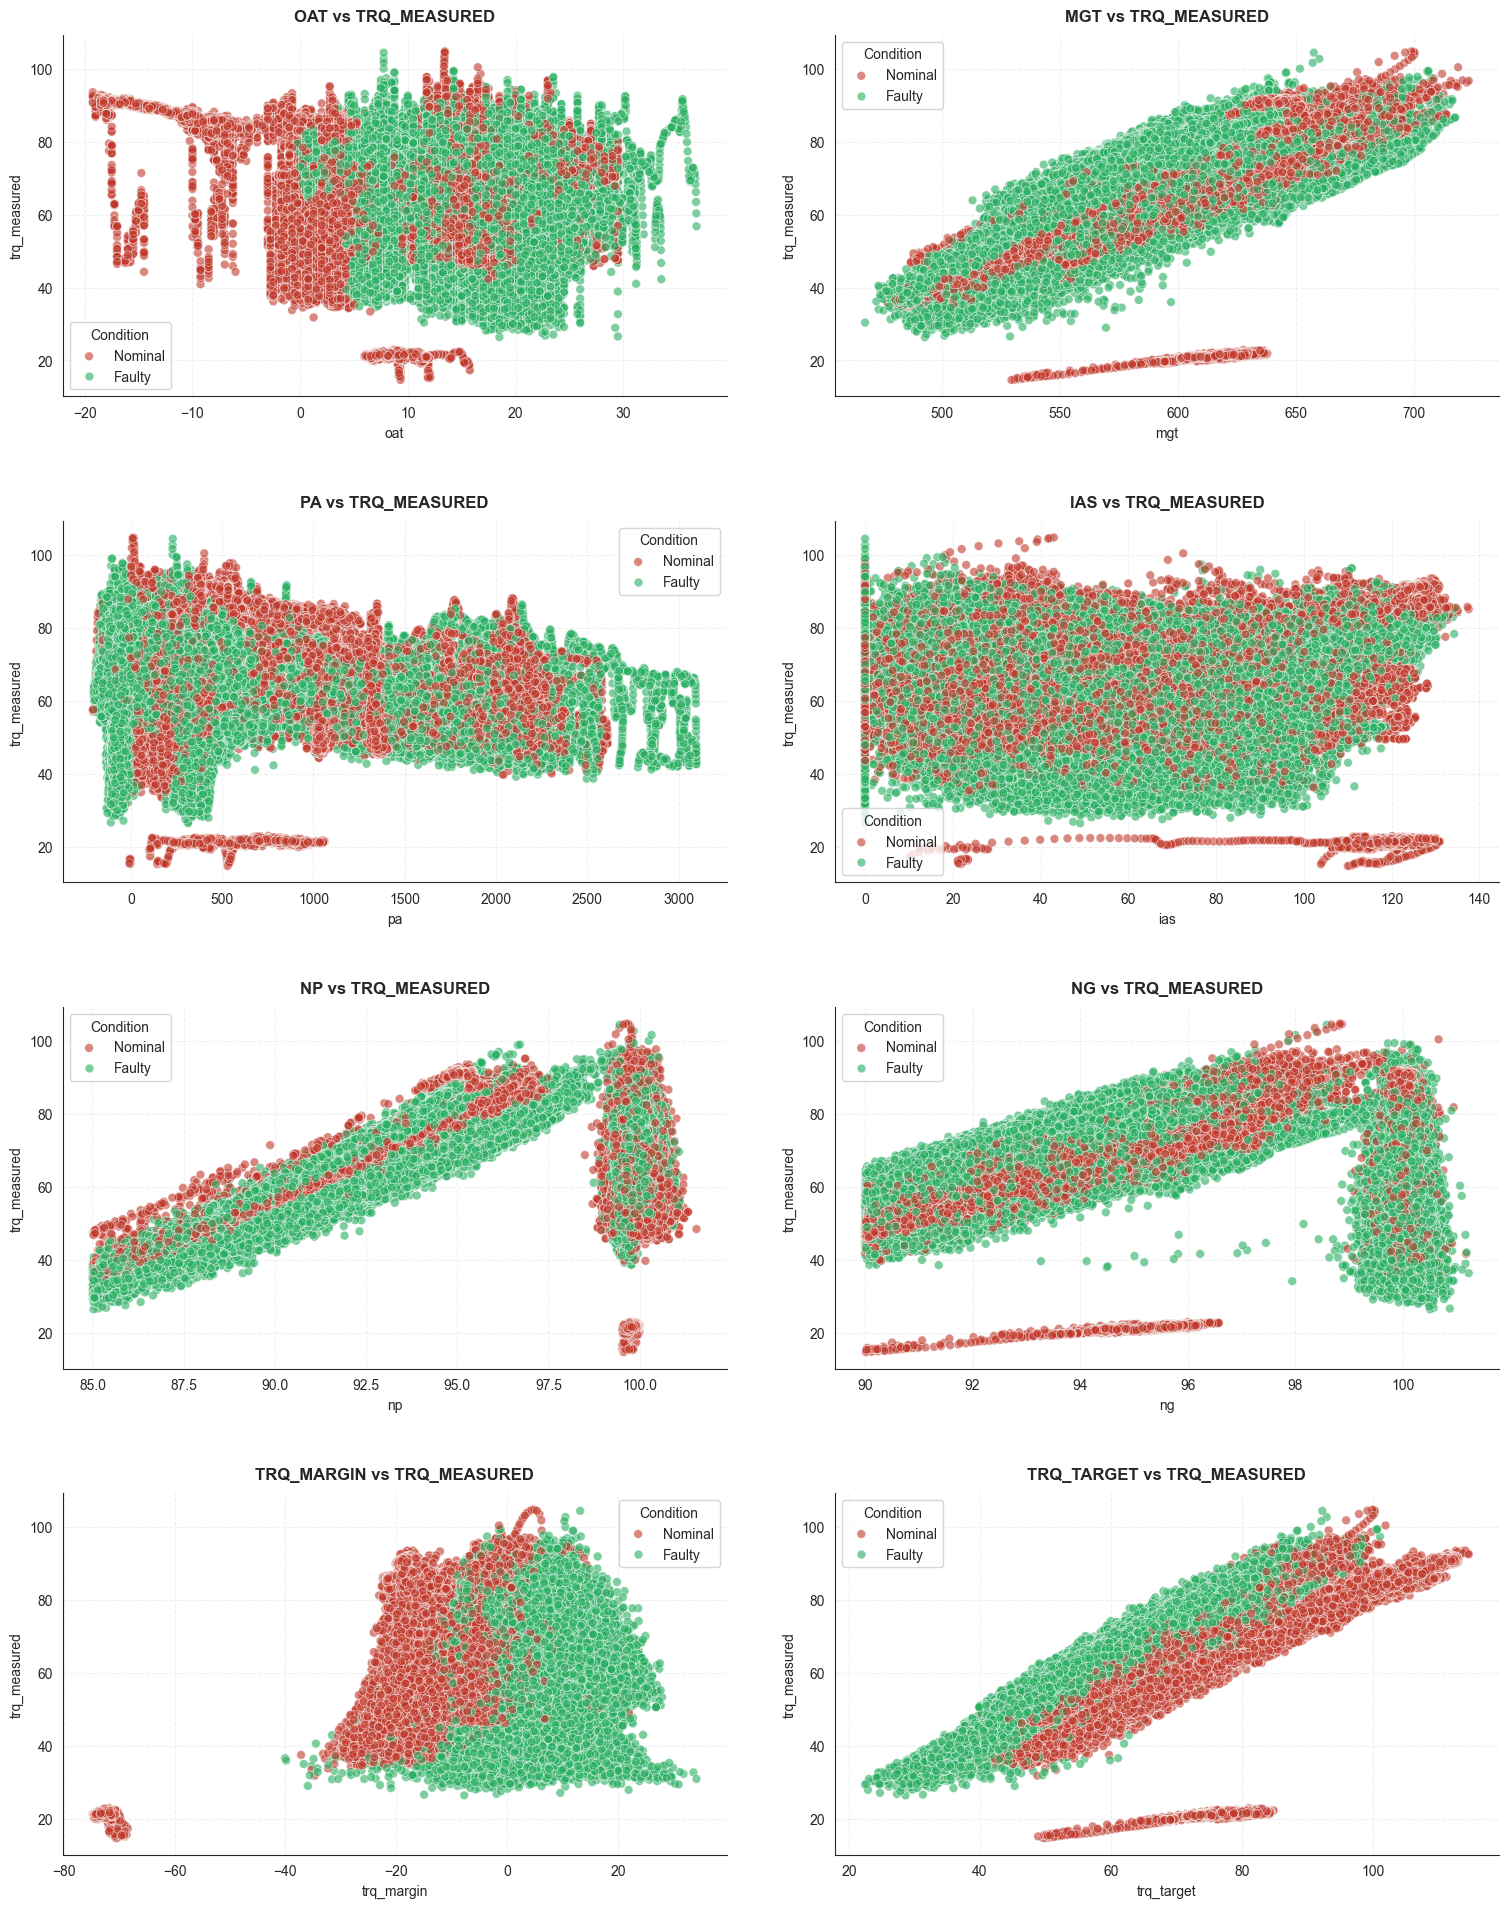

In [11]:
target_x = 'trq_measured'
features = [col for col in df.columns if col not in [target_x, 'id', 'faulty']]

n_cols = 2
n_rows = math.ceil(len(features) / n_cols)

plt.figure(figsize=(16, n_rows * 5))
sns.set_style("white")

for i, feature in enumerate(features, 1):
    ax = plt.subplot(n_rows, n_cols, i)

    sns.scatterplot(
        data=df,
        x=feature,
        y=target_x,
        hue='faulty',
        palette={0: "#27ae60", 1: "#c0392b"},
        alpha=0.6,
        s=40,
        edgecolor='w',
        linewidth=0.5
    )

    sns.despine()
    ax.set_title(f"{feature.upper()} vs {target_x.upper()}", fontsize=12, fontweight='bold', pad=10)
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.legend(title='Condition', labels=['Nominal', 'Faulty'], loc='best', frameon=True)

plt.tight_layout(pad=4.0)
plt.show()

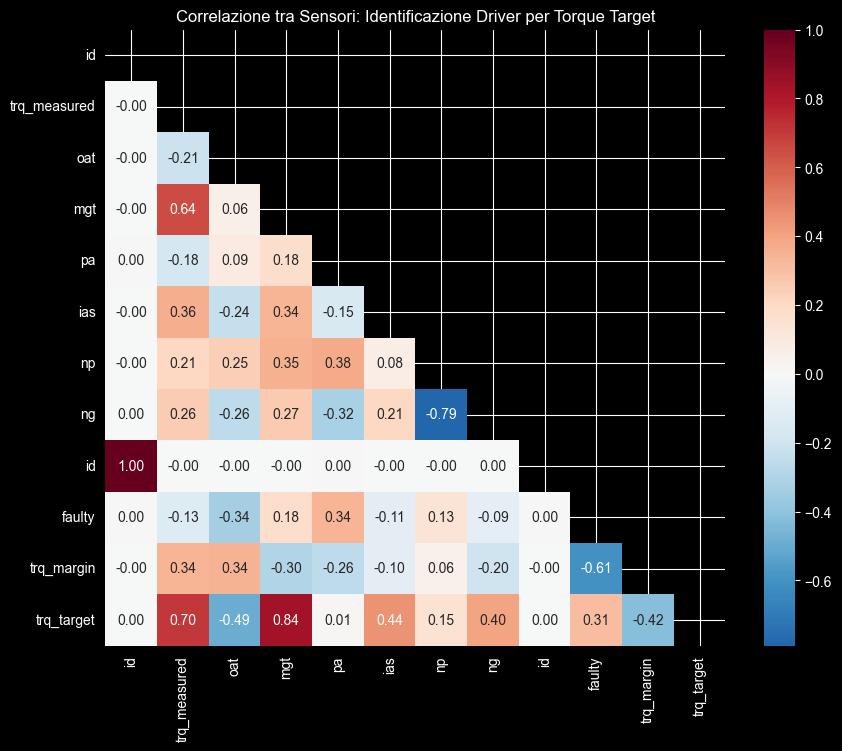

In [4]:
import numpy as np

plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(df.corr(), dtype=bool)) # Maschera per non vedere doppioni
sns.heatmap(df.corr(), mask=mask, annot=True, cmap='RdBu_r', center=0, fmt=".2f")
plt.title("Correlazione tra Sensori: Identificazione Driver per Torque Target")
plt.show()